# Figure 3 Hierarchical Bayesian Modelling.

## **NOTE**:

We assume that you have cloned the analysis repository and have `cd` into the parent directory. Before starting with the analysis make sure you have first completed the dependencies set up by following the instructions described in the **`dependencies/README.md`** document. All paths defined in this Notebook are relative to the parent directory (repository). Please close this Notebook and start again by following the above guidelines if you have not completed the aforementioned steps.

## Loading dependencies

In [5]:
Sys.setenv(TAR = "/bin/tar")
# dataviz dependencies
library(ggplot2)
library(visdat)
library(patchwork)
library(ggsci)
library(grid)
library(gridExtra)
library(coda)
library(rstan)


# BDA2E-utilities dependencies
library(parallel)
library(rjags)
library(runjags)
library(compute.es)

Loading required package: StanHeaders

rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


Attaching package: ‘rstan’


The following object is masked from ‘package:runjags’:

    extract


The following object is masked from ‘package:coda’:

    traceplot




In [4]:
# Download GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct from Google Cloud 
if (!("GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct" %in% list.files("../data/"))) {
    message("Downloading GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct \nfrom https://console.cloud.google.com/storage/browser/_details/gtex_analysis_v7/rna_seq_data/ ..")
    system("wget -O ../data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz https://storage.googleapis.com/gtex_analysis_v7/rna_seq_data/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct.gz", intern = TRUE)
    message("Done!\n\n")
    message("Unzipping compressed file GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz..")
    system("gunzip ../data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz", intern = TRUE)
    message("Done! \n\nThe file GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct can be found in ../data/")
}

from https://console.cloud.google.com/storage/browser/_details/gtex_analysis_v7/rna_seq_data/ ..



In [ ]:
##Change local paths: 

In [6]:
tissue.list<-c('Heart - Left Ventricle',
               'Breast - Mammary Tissue',
               'Brain - Cortex.Brain - Frontal Cortex (BA9).Brain - Anterior cingulate cortex (BA24)',
               'Adrenal Gland',
               'Adipose - Subcutaneous',
               'Muscle - Skeletal',
               'Thyroid',
               'Cells - Transformed fibroblasts',
               'Artery - Aorta',
               'Skin - Sun Exposed (Lower leg).Skin - Not Sun Exposed (Suprapubic)')

tissue<-tissue.list[1]  #can be replaced with a loop or argument to choose a different tissue

file.with.de.results<-paste('/Users/karleg/Dimorph/other/',tissue,'se.txt',sep='') 

rbp.table.name<-'/Users/karleg/Dimorph/splice-relevant-genes.txt'

events.table.name<-'/Users/karleg/Dimorph/fromGTF.SE.txt.1'

inc.counts.file.name<-'/Users/karleg/Dimorph/rmats_final.se.jc.ijc.txt'

skip.counts.file.name<-'/Users/karleg/Dimorph/rmats_final.se.jc.sjc.txt'

metadata.file.name<-'/Users/karleg/Dimorph/SraRunTable.noCram.noExome.noWGS.totalRNA.txt'

expression.file.name<-'/Users/karleg/Dimorph/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct'


##  Figure 3a

This figure is a diagram to explain the modeling and therefore not included here

In [6]:
##  Load the skip and inclusion count matrices, and the list of RNA binding proteins that are annotated to either mRNA splicing, via spliceosome (GO:0000398),
## regulation of mRNA splicing, via spliceosome (GO:0048024), or both. The table has the Gene Symbol, the Uniprot ID (uprot.id), the NCBI Gene ID (gene.id) and boolean columns for being S=mRNA splicing, via spliceosome (GO:0000398) and R=regulation of mRNA splicing, via spliceosome (GO:0048024).

In [9]:
events.table<-read.table(file.with.de.results)

events.table=events.table[abs(events.table$logFC)>=log2(1.5) & events.table$adj.P.Val<=0.05,]

annot.table<-read.table(events.table.name,header=T)

rownames(annot.table)<-annot.table$ID

merged.table<-merge(events.table,annot.table,by='row.names')

rbp.table<-read.table(rbp.table.name,sep='\t',header=TRUE)  

inc.counts<-read.csv(inc.counts.file.name)

skip.counts<-read.csv(skip.counts.file.name)


In [ ]:
#Read sample info

In [10]:
meta.data<-read.csv(metadata.file.name,header=TRUE)

meta.data<-meta.data[meta.data$body_site==tissue,]

inc.counts<-inc.counts[,colnames(inc.counts) %in% meta.data$Run]

skip.counts<-skip.counts[,colnames(skip.counts) %in% meta.data$Run]

sd.threshold<-quantile(apply(inc.counts,1,sd)+apply(skip.counts,1,sd),0.95)

skip.counts=skip.counts[rownames(skip.counts) %in% merged.table$Row.names,]

inc.counts=inc.counts[rownames(inc.counts) %in% merged.table$Row.names,]

if (nrow(skip.counts)>100)
{
  select.events<-apply(inc.counts,1,sd)+apply(skip.counts,1,sd)>sd.threshold
  
  inc.counts<-inc.counts[select.events,]

  skip.counts<-skip.counts[select.events,]

  merged.table<-merged.table[select.events,]
}

In [ ]:
##Read expression data:

In [11]:
expression.mat<-read.table(expression.file.name, nrows=1,sep='\t',header=T,skip=2)

colnames.expression.mat<-colnames(expression.mat)

total.samples<-length(colnames.expression.mat)

meta.data$Sample.Name<-gsub('-','\\.',meta.data$Sample.Name)

meta.data<-meta.data[meta.data$Sample.Name %in% colnames(expression.mat),]

meta.data<-meta.data[!duplicated(meta.data$Sample.Name),]

inc.counts<-inc.counts[,colnames(inc.counts) %in% meta.data$Run]

skip.counts<-skip.counts[,colnames(skip.counts) %in% meta.data$Run]

meta.data<-meta.data[meta.data$Run %in% colnames(inc.counts),]

col.in.tissue<-c()

for (col in colnames.expression.mat)
  
  col.in.tissue<-c(col.in.tissue, (col %in% meta.data$Sample.Name) && (meta.data$body_site[which(meta.data$Sample.Name==col)] %in% tissue) && (meta.data$submitted_subject_id[which(meta.data$Sample.Name==col)]!='GTEX-11ILO'))

expression.mat<-read.table(expression.file.name, colClasses = ifelse(col.in.tissue,"numeric","NULL"),sep='\t',header=T,skip=2)


In [ ]:
#Read gene names:

In [12]:
expression.mat<-expression.mat[,order(match(colnames(expression.mat),meta.data$Sample.Name))]

inc.counts<-inc.counts[,order(match(colnames(inc.counts),meta.data$Run))]

skip.counts<-skip.counts[,order(match(colnames(skip.counts),meta.data$Run))]

all.genes<-read.table(expression.file.name,sep='\t',header=T,skip=2,colClasses = c(rep("character", 2), rep("NULL", total.samples-2)))

expression.mat<-expression.mat[!duplicated(all.genes$Description),]

all.genes<-all.genes[!duplicated(all.genes$Description),]

skip.counts<-skip.counts[merged.table$geneSymbol %in% all.genes$Description,]

inc.counts<-inc.counts[merged.table$geneSymbol %in% all.genes$Description,]

merged.table<-merged.table[merged.table$geneSymbol %in% all.genes$Description,]

gene.names=unique(merged.table$geneSymbol)

expression.mat<-expression.mat[all.genes$Description %in% c(as.character(rbp.table$Gene),as.character(gene.names)),]

rownames.expression.mat<-all.genes$Description[all.genes$Description %in% c(as.character(rbp.table$Gene),as.character(gene.names))]

expression.mat<-expression.mat[!duplicated(rownames.expression.mat),]

rownames.expression.mat<-rownames.expression.mat[!duplicated(rownames.expression.mat)]


In [ ]:
#Prepare expression of genes and RBPS:

In [11]:
num.events=nrow(merged.table)

event.to.gene=c()

gexp=expression.mat[rownames.expression.mat %in% gene.names,]

rownames(gexp)<-rownames.expression.mat[rownames.expression.mat %in% gene.names]

gexp<-gexp[order(match(rownames(gexp),gene.names)),]

gexp=log2(gexp+0.5)

gexp=gexp-rowMeans(gexp)

gexp[apply(gexp,1,sd)>0,]=gexp[apply(gexp,1,sd)>0,]/apply(gexp[apply(gexp,1,sd)>0,],1,sd)

rexp=expression.mat[rownames.expression.mat %in% rbp.table$Gene,]

rownames(rexp)<-rownames.expression.mat[rownames.expression.mat %in% rbp.table$Gene]

rexp<-rexp[order(match(rownames(rexp),rbp.table$Gene)),]

rexp=log2(rexp+0.5)

rexp=rexp-rowMeans(rexp)

rexp=rexp/apply(rexp,1,function(v){ifelse(sum(v==v[1])<length(v),sd(v),1)})

for (i in (1:num.events))
  
  event.to.gene<-c(event.to.gene,which(unique(merged.table$geneSymbol)==merged.table[i,'geneSymbol']))

sex<-ifelse(meta.data$sex=='male',1,0)


In [10]:
#Run stan:

  [1] 1 1 0 1 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 0
 [38] 1 1 1 1 0 1 1 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1
 [75] 1 1 0 1 0 0 0 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0
[112] 1 1 1 1 1 0 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 0 1 1 0 1
[149] 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 1 1 0 0 1 0
[186] 1 1 1 1 0 1 0 1


In [16]:
dataList = list(
  as = round(skip.counts) ,   #skip event counts across experiments
  c = round(skip.counts+inc.counts)    , #total counts for event, i.e. skip+inclusion, across experiments
  gexp = gexp, #read counts for genes (from gtex, take the raw counts) across experiments
  rexp = rexp, #read counts for RBPs (from gtex, take the raw counts)
  event_to_gene = event.to.gene,  #the gene index for each event (1 to the number of distinct genes) 
  Nrbp = nrow(rexp), #number of RBPs
  Nevents = nrow(merged.table),  #most varying AS events in 
  Nexp = ncol(expression.mat),#number of experiments such that we measured each event, gene and RBP in each experiment
  Ngenes = nrow(gexp),
  sex=sex
)


modelString = "
data {
int<lower=0> Nevents;
int<lower=0> Nexp;
int<lower=0> Nrbp;
int<lower=0> Ngenes;
int<lower=0> as[Nevents,Nexp] ;
int<lower=0> c[Nevents,Nexp] ;
matrix[Ngenes,Nexp] gexp ; 
matrix[Nrbp,Nexp] rexp ; 
int<lower=0> event_to_gene[Nevents];
int<lower=0,upper=1> sex[Nexp];

}


parameters {
real beta0[Nevents] ;
real beta1[Nevents] ;
matrix[Nevents,Nrbp] beta2 ;
real beta3[Nevents];
real beta4[Nrbp];

}
model {

for ( i in 1:Nexp ) {  


    for ( j in 1:Nevents ) if (c[j,i]>0) { 

      as[j,i] ~ binomial(c[j,i], inv_logit(beta0[j]+beta1[j]*sex[i]+dot_product(beta2[j,],rexp[,i])+beta3[j]*gexp[event_to_gene[j],i] ) );

  }
}

for (k in 1:Nrbp){

  for ( j in 1:Nevents ) { 

        beta2[j,k] ~normal(beta4[k],1);
  }

  beta4[k]~normal(0,1);

}


for ( j in 1:Nevents ) { 

    beta1[j] ~ normal(0,1);
    beta0[j] ~ normal(0,1);
    beta3[j] ~ normal(0,1);
  }

}
"

stanDso <- stan_model( model_code=modelString ) 

stanFit <- sampling( object=stanDso , data = dataList , chains = 3 ,iter = 8000,warmup=6000   , thin = 1,init=0, cores=3 )

mcmcCoda = mcmc.list( lapply( 1:ncol(stanFit) , function(x) { mcmc(as.array(stanFit)[,x,]) } ) )


In [2]:
source("/Users/karleg/Downloads/dimorpAS-master/DBDA2Eprograms/DBDA2E-utilities.R")


*********************************************************************
Kruschke, J. K. (2015). Doing Bayesian Data Analysis, Second Edition:
A Tutorial with R, JAGS, and Stan. Academic Press / Elsevier.
*********************************************************************



Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs



## Initialising dataframe with columns `coef,rbp,tissue`

In [17]:
df <-data.frame(coef=NULL,rbp=NULL,tissue=NULL)


In [27]:
#Before running the following, use the Session menu to set working directory to source file location
#setwd(dir = "../dimorphAS/DBDA2Eprograms/")
load('../dimorphAS/figures/oldFigureDrafts/figure3b.RData')

### This invokes X11 which is not available for all systems, and won't work in a NextFlow pipeline

```
diagMCMC(mcmcCoda , parName=c("beta2[101,87]"))
```

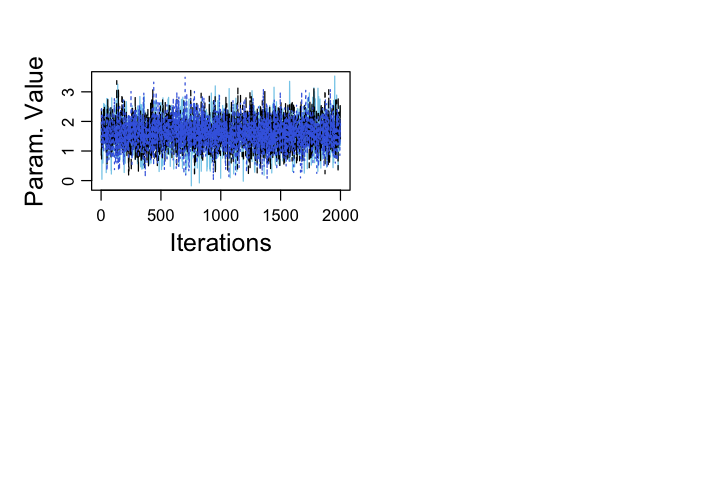

In [8]:
options(repr.plot.width=6, repr.plot.height=4)

codaObject <- mcmcCoda 
parName    <- c("beta2[101,87]") #varnames(codaObject)[1]
saveName   <- NULL
saveType   <- "jpg"


DBDAplColors = c("skyblue",
               "black",
               "royalblue",
               "steelblue")

#openGraph(height=5,width=7)
    
par(mar=0.5+c(3,4,1,0) , 
  oma=0.1+c(0,0,2,0) , 
  mgp=c(2.25,0.7,0) , 
  cex.lab=1.5 )
    
layout(matrix(1:4,nrow=2))
  # traceplot and gelman.plot are from CODA package:
require(coda)
coda::traceplot( codaObject[,c(parName)], 
              main="" , 
              ylab="Param. Value" ,
              col=DBDAplColors )

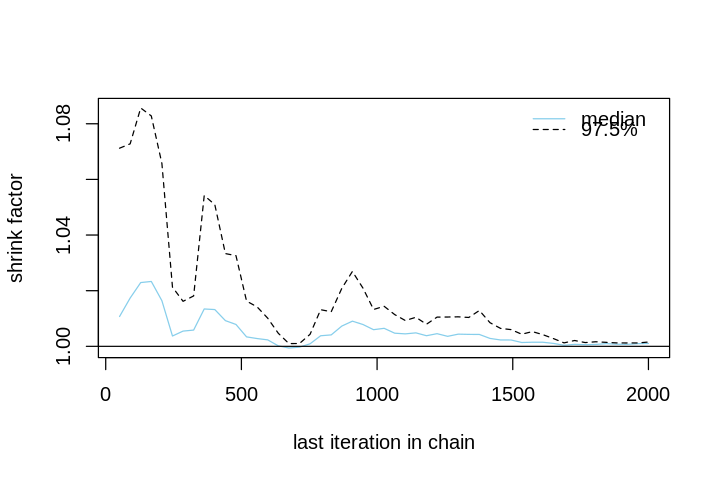

In [52]:
options(repr.plot.width=6, repr.plot.height=4)
tryVal = try(
coda::gelman.plot(codaObject[,c(parName)] , 
                  main="",
                  auto.layout=FALSE,
                  col=DBDAplColors )
)  

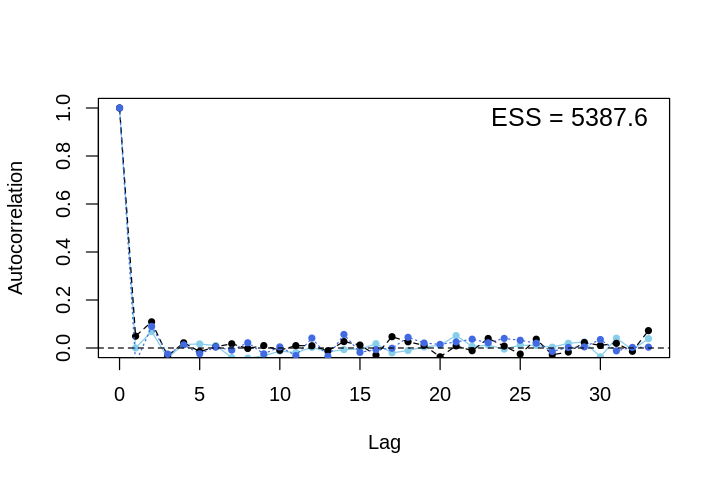

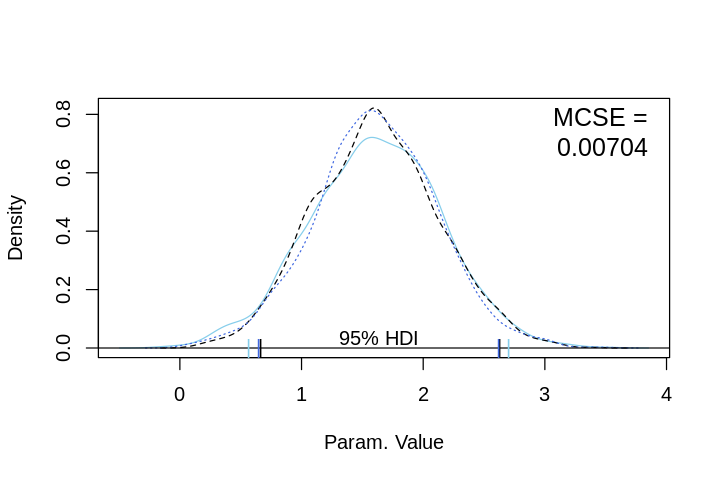

In [51]:
options(repr.plot.width=6, repr.plot.height=4)

# if it runs, gelman.plot returns a list with finite shrink values:
  if ( class(tryVal)=="try-error" ) {
    plot.new() 
    print(paste0("Warning: coda::gelman.plot fails for ",parName))
  } else { 
    if ( class(tryVal)=="list" & !is.finite(tryVal$shrink[1]) ) {
      plot.new() 
      print(paste0("Warning: coda::gelman.plot fails for ",parName))
    }
  }
  DbdaAcfPlot(codaObject,parName,plColors=DBDAplColors)
  DbdaDensPlot(codaObject,parName,plColors=DBDAplColors)
  mtext( text=parName , outer=TRUE , adj=c(0.5,0.5) , cex=2.0 )
  if ( !is.null(saveName) ) {
    saveGraph( file=paste0(saveName,"Diag",parName), type=saveType)
  }



In [ ]:
##Collect coefficients for RBPs whose 95% HDI does not contain 0:

In [ ]:
rbp.names<-rownames(rexp)

df<-data.frame(coef=NULL,rbp=NULL,tissue=NULL)

hdi<-HPDinterval(mcmcCoda)  

s <- summary(mcmcCoda)

m <- s$statistics[,"Mean"]

beta2.mat<-matrix(nrow=nrow(merged.table),ncol=length(rbp.names))

for (rbp in (1:length(rbp.names)))
  
  for (event in (1:nrow(merged.table)))
  {
    
    var.name<-paste0('beta2[',event,',',rbp,']')
    
    low<-hdi[[1]][rownames(hdi[[1]])==var.name][1]
    
    high<-hdi[[1]][rownames(hdi[[1]])==var.name][2]
    
    beta2.mat[event,rbp]<-m[grepl(paste0('beta2\\[',event,',',rbp,'\\]'),names(m))]
    
    if (low<0 && high>0)
      
      beta2.mat[event,rbp]<-0
    
  }



colnames(beta2.mat)=rbp.names

for (rbp in rbp.names)
  
  df<-rbind(df,cbind(beta2.mat[,colnames(beta2.mat)==rbp],rep(rbp,nrow(beta2.mat)),rep(tissue,nrow(beta2.mat)))  )


colnames(df)<-c('Coef','RBP','Tissue')
    
df$Coef<-as.numeric(as.character(df$Coef))


In [ ]:
##Display a violin plot for some selected RBPs:

In [ ]:
labels<-read.table('/Users/karleg/Dimorph/labels.tsv',sep='\t',header=T)

df$Tissue<-as.character(df$Tissue)

for (i in 1:nrow(df))
  
  if (df$Tissue[i] %in% labels$tissue)
    
    df$Tissue[i]<-as.character(labels$X[which(as.character(labels$tissue)==as.character(df$Tissue[i]))])


df<-df[df$Coef!=0,]


df$RBP<-as.character(df$RBP)

df1<-df[df$RBP %in% c("BUD13", "GTF2F1","CTNNBL1"),]

pn1<-ggplot(df1,aes(factor(RBP),Coef)) + geom_violin(aes(fill='red')) + scale_fill_manual(values = '#4DBBD5FF') 

pn1 <- pn1 + theme_minimal() +  theme(text = element_text(size=20),
                                      axis.text = element_text(size=20, hjust=0.5),
                                      axis.title.x=element_blank(),
                                      axis.title.y = element_text(size=24),
                                      plot.title = element_text(hjust = 0.5),
                                      legend.position = "none") + ylab("") + labs(title="")+ylim(-2,2)+ geom_hline(yintercept=0)



In [ ]:
##Create barplot of the number of RBPs that tend to promote skipping, the number of RBPs that tend to promote
#inclusion and the number of RBPs whose effect is context-specific, for the two RBP groups

In [ ]:
spliceosome_genes = as.character(rbp.table$Gene[rbp.table$S=='TRUE'])

splice_regulation_genes = as.character(rbp.table$Gene[rbp.table$R=='TRUE'])

for (RBP_set in list(spliceosome=spliceosome_genes,splice_regulation=splice_regulation_genes))
{
  sum.pos<-sort(unlist(lapply(lapply(split(df$Coef[df$RBP %in% RBP_set],df$RBP[df$RBP %in% RBP_set]),'>',0),sum)),decreasing = T)
  
  sum.neg<-sort(unlist(lapply(lapply(split(df$Coef[df$RBP %in% RBP_set],df$RBP[df$RBP %in% RBP_set]),'<',0),sum)),decreasing = T)
  
  sum.pos<-sum.pos[order(names(sum.pos))]
  
  sum.neg<-sum.neg[order(names(sum.neg))]
  
  pos.rbps<-names(which(sum.pos/(sum.pos+sum.neg)>=0.75 & (sum.pos+sum.neg>quantile(sum.pos+sum.neg,0.2))))
  
  neg.rbps<-names(which(sum.pos/(sum.pos+sum.neg)<=0.25 & (sum.pos+sum.neg>quantile(sum.pos+sum.neg,0.2))))
  
  cs.rbps<-names(which(sum.pos/(sum.pos+sum.neg)>0.25 & sum.pos/(sum.pos+sum.neg)<0.75 & (sum.pos+sum.neg>quantile(sum.pos+sum.neg,0.2))))
  
  df.counts<-data.frame(type=c('Skip','Inc','CS'),counts=c(length(pos.rbps),length(neg.rbps),length(cs.rbps)))
  
  pn4_new <- ggplot(df.counts, aes(type, counts)) +  
    geom_bar(fill = "#00008B",color="black", position = "dodge", stat="identity") + 
    geom_text(aes(x = type, y = counts + 10, label = paste(100 * round(counts/sum(counts), 3), "%", sep = "")), size = 3) +
    guides(fill=FALSE) +
    xlab("") + scale_y_continuous(breaks = c(0, 20, 40), limits = c(0, 60))+
    theme_minimal() +
    theme(
      axis.text = element_text(size = 8), 
      axis.text.x = element_text(angle = 90, hjust = 1), 
      axis.title = element_text(size = 10),
      axis.title.y = element_text(vjust = 5)
    )
  show(pn4_new  )
}




In [25]:
if ( ("lv.txt" %in% list.files("../data/")) && ("mt.txt" %in% list.files("../data/"))) {
        message("The files lv.txt or mt.txt are available in the folder ../data/! \n")
        message("The 'perl parseMT.pl' command will not be re-run \n")
}


if ( (!("lv.txt" %in% list.files("../data/"))) | (!("mt.txt" %in% list.files("../data/")))) {
        message("The files lv.txt or mt.txt not found in the folder ../data/ \n")
        message("Generating lv.txt and mt.txt with 'perl parseMT.pl' using 'summary_hbm.txt' as input .. \n")
        system(paste0("cd ../dimorphAS/notebook/ && ",
                      "perl parseMT.pl > parseMT_output.txt && ", 
                      "mv lv.txt ../../data/ && ",
                      "mv mt.txt ../../data/ && ",
                      "cp summary_hbm.txt  ../../data/"), 
               intern  = TRUE)
        message("Done!\n")
}



The files lv.txt or mt.txt are available in the folder ../data/! 

The 'perl parseMT.pl' command will not be re-run 



## Metadata

For replicability and reproducibility purposes, we also print the following metadata:

1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

### 1. Checksums with the sha256 algorithm

In [38]:
figure_id       <- "figures_3"

message("Generating sha256 checksums of the artefacts in the `..data/` directory .. ")
system(paste0("cd ../data/ && find . -type f -exec sha256sum {} \\; > ../metadata/",  figure_id, "_sha256sums.txt"), intern = TRUE)
message("Done!\n")

data.table::fread(paste0("../metadata/", figure_id, "_sha256sums.txt"), header = FALSE, col.names = c("sha256sum", "file"))

Generating sha256 checksums of the artefacts in the `..data/` directory .. 


character(0)

Done!



sha256sum,file
<chr>,<chr>
e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855,./README.md
7620b9a77e88b7879af22eb27136e94c993e92a287058bfa3e22244d3963975e,./mt.txt
ec38fac35613da014f73140da90c95294ba52c6e7923e380a5236762f1ca3793,./GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct
947b61563e51232c3276cd4b44d3414d68ea9a419dc74d09375d2bfbb321f08b,./summary_hbm.txt
791589cf6a262a89808f0653db4d01715c5bd92381e53521ccdca3fcc075953c,./RBP_PSSMs/RBM4_gcgcgss_human_PSSM.txt
e2da6d12f918bab56f05c905deee4cec77e224bc1784b22199cd83c750c0d52a,./RBP_PSSMs/TARDBP_gaaugd_human_PSSM.txt
eb8e7624f93a768fe24412f4c070eb86857b1ed9b8defdbf5be29b2da77e98a3,./RBP_PSSMs/ARET_ukukugu_drosophila_PSSM.txt
c807b997c6fabafec009015be164645e3ba8edf453845b60a276eeff6b79e577,./RBP_PSSMs/HNRNPL_amayama_human_PSSM.txt
97e86fc27a363ebd20e7857c0cae7281b3ef3e5721314f020cc40402059ef25c,./RBP_PSSMs/HNRNPA2B1_gguaguag_human_PSSM.txt


### 2. Libraries metadata

In [39]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../metadata/", figure_id, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../metadata/", figure_id ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]

Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..
Done!

Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..
Done!



 setting  value                       
 version  R version 3.6.1 (2019-07-05)
 os       Ubuntu 18.04.3 LTS          
 system   x86_64, linux-gnu           
 ui       X11                         
 language en_US.UTF-8                 
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       Etc/UTC                     
 date     2020-03-09                  

,package,ondiskversion,loadedversion,path,loadedpath,attached,is_base,date,source,md5ok,library
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<fct>
coda,coda,0.19.3,0.19-3,/opt/conda/lib/R/library/coda,/opt/conda/lib/R/library/coda,TRUE,FALSE,2019-07-05,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
compute.es,compute.es,0.2.4,0.2-4,/opt/conda/lib/R/library/compute.es,/opt/conda/lib/R/library/compute.es,TRUE,FALSE,2014-09-16,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
ggplot2,ggplot2,3.2.1,3.2.1,/opt/conda/lib/R/library/ggplot2,/opt/conda/lib/R/library/ggplot2,TRUE,FALSE,2019-08-10,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
ggsci,ggsci,2.9,2.9,/opt/conda/lib/R/library/ggsci,/opt/conda/lib/R/library/ggsci,TRUE,FALSE,2018-05-14,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
patchwork,patchwork,1.0.0,1.0.0,/opt/conda/lib/R/library/patchwork,/opt/conda/lib/R/library/patchwork,TRUE,FALSE,2019-12-01,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
report,report,0.1.0,0.1.0,/opt/conda/lib/R/library/report,/opt/conda/lib/R/library/report,TRUE,FALSE,2020-03-04,Github (easystats/report@dcdd283),NA,/opt/conda/lib/R/library
rjags,rjags,4.10,4-10,/opt/conda/lib/R/library/rjags,/opt/conda/lib/R/library/rjags,TRUE,FALSE,2019-11-06,CRAN (R 3.6.2),NA,/opt/conda/lib/R/library
runjags,runjags,2.0.4.6,2.0.4-6,/opt/conda/lib/R/library/runjags,/opt/conda/lib/R/library/runjags,TRUE,FALSE,2019-12-17,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
visdat,visdat,0.5.3,0.5.3,/opt/conda/lib/R/library/visdat,/opt/conda/lib/R/library/visdat,TRUE,FALSE,2019-02-15,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
